In [ ]:
import pandas as pd
import wandb
from tqdm import tqdm

api = wandb.Api()
entity, project = "st7ma784", "Bertscore"
runs = api.runs(entity + "/" + project)
metric_to_Grab=["F1"]
Group_by=[#"modelname",
"modelname",
"LSAVersion",
#"perfect_match",
#"padding_length"
]
ignore_values=["albert-base-v2","roberta-base"]
data={}
options={k:set() for k in Group_by}
print("Grabbing data:")
run_configs=set()
for run in tqdm(runs):
       
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        hist=run.history()
        # print(hist)
        config=run.config
        #print(config)        
        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        items=list([str(config[i]) for i in sortedkeys])
        code="_".join(items)
        if not any([item in ignore_values for item in config.items()]) and config["batch_size"]==180 and code not in run_configs:
            run_configs.add(code)

            dictkeys=list(set(config.keys()).intersection(set(Group_by)))
            dictkeys.sort()
            for k in dictkeys:
                s=options[k]
                s.add(config.get(k,""))
                options[k]=s
            entry_name= "_".join([config.get(k,"") for k in dictkeys])
            #print(entry_name)

            dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
            for k in dictkeys:
                lis=data.get(entry_name,[])
                lis.extend(hist[k])
                data[entry_name]=lis
    
    
        # for k in dictkeys:
        #     summarydict[k].append(hist[k])



In [ ]:
options

In [ ]:
import seaborn as sns
# %matplotlib_inline
import matplotlib.pyplot as plt

figure=plt.figure()
i=0
for key in options:
    for entry in options[key]:
        #filter data by data.key() includes entry
        newdict={k:v for k,v in data.items() if entry in k.split("_")}
        figure=plt.figure(i)
        i+=1
        plot=sns.histplot(data=newdict, kde = True,)
        

In [ ]:
#proof of concept. 

#We're going to take all runs, and then do a set of configs,

#During creation of the set, if there is the same config with 384 and 128 for padding length, we're going to plot a histogram of each set of results. 
import pandas as pd
import wandb
from tqdm import tqdm
from itertools import chain

api = wandb.Api()
entity, project = "st7ma784", "Bertscore"
runs = api.runs(entity + "/" + project)
metric_to_Grab=["F1"]
ignore_values=["albert-base-v2","roberta-base"]
data={}
print("Grabbing data:")
codepairs=[]
run_configs=set()
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config
        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        values=list([str(config[i]) for i in sortedkeys])
        code="_".join(values)
        if not any([item in ignore_values for item in config.values()]) and config["batch_size"]==180:
            run_configs.add(code)
for code in run_configs:
    othercode=code
    if "128" in code:
        othercode=code.replace("128","384")
    elif "384" in code:
        othercode=code.replace("384","128")
    if othercode in run_configs:
        codepairs.append((code,othercode))

tests={}
print("saving runs where tests exist")
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        print(sortedkeys)
        values=list([str(config[i]) for i in sortedkeys])
        code="_".join(values)

        if code in chain.from_iterable(codepairs):
            newcode=code.replace("128","")
            newcode=newcode.replace("384","")
            hist=run.history()
            
            dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
            for k in dictkeys:
                lis=tests.get(newcode,{})
                code="Padding Length = {}".format(128 if "128" in code else 384)
                lis[code]=hist[k]
                tests[newcode]=lis


In [ ]:
import seaborn as sns
# %matplotlib_inline
import matplotlib.pyplot as plt
from tqdm import tqdm
figure=plt.figure()
i=0
for key in tqdm(tests):
    if key.startswith("none"):
        figure=plt.figure(i)
        i+=1
        plot=sns.histplot(data=tests[key], kde = True,)
        print(key)

We're going to generalise the above code block to allow us to generate graphs of any set of sweep that is comprehensive 

In [ ]:
tests={}
print("saving runs where tests exist")
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        # print(sortedkeys)
        values=list([str(config[i]) for i in sortedkeys])
        code="_".join(values)
        for group in codesets:
            if code in group[1]:
                key=group[0]
                args=code.split("_")
                argindex=sortedkeys.index(key)
                value=code.split("_")[argindex]
                first=args[:argindex] if argindex>0 else []
                last=args[argindex:] if argindex != len(args)-1 else []
                testname="_".join(first+last)

                hist=run.history()
            
                dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
                for k in dictkeys:
                    lis=tests.get(testname,{})
                    code="{} = {}".format(key,value)
                    lis[code]=hist[k]
                    tests[testname]=lis

In [3]:
#proof of concept. 

#We're going to take all runs, and then do a set of configs,

#During creation of the set, if there is the same config with 384 and 128 for padding length, we're going to plot a histogram of each set of results. 
import pandas as pd
import wandb
from tqdm import tqdm
from itertools import chain

api = wandb.Api()
entity, project = "st7ma784", "Bertscore"
runs = api.runs(entity + "/" + project)
metric_to_Grab=["F1"]
ignore_values=[]#"albert-base-v2","roberta-base"]
keys_of_interest=set(["LSAVersion","all_layers","modelname","padding_length","perfect_match"])
data={}
print("Grabbing data:")
codepairs=[]
run_configs=set()
keyvaluesets={}

'''Code to find all runs that have completed'''
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys() if i in keys_of_interest])
        sortedkeys.sort()
        values=list([str(config[i]) for i in sortedkeys if i in keys_of_interest])
        for k,v in zip(sortedkeys,values):
            valueset=set(keyvaluesets.get(k,[]))
            valueset.add(v)
            keyvaluesets[k]=list(valueset)
        code="_".join(values)
        if not any([item in ignore_values for item in config.values()]) and config["batch_size"]==180:
            run_configs.add(code)

'''
A code block that searches each key that show the unique affect of a key in a set of runs.     
'''
for item in keyvaluesets.items():
    print(item)
codesets=[]
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config
        sortedkeys=list([str(i) for i in config.keys() if i in keys_of_interest])
        sortedkeys.sort()
        for i,key in enumerate(sortedkeys):
            #get all values of key
            possible_values=keyvaluesets[key]
            codes=[]
            for v in possible_values:
                codes.append(list([str(config[i]) if i!=key else v for i in sortedkeys]))       
            codes=["_".join(code) for code in codes]
            # print(codes)
            if all([code in run_configs for code in codes]):
                codesets.append((key,tuple(codes)))

#remove duplicates in codesets
                
codesets=list(set(codesets))
# for s in codesets:
#     print(s)#Gather data
tests={}
print("saving runs where tests exist")
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys() if i in keys_of_interest])
        sortedkeys.sort()
        # print(sortedkeys)
        values=list([str(config[i]) for i in sortedkeys if i in keys_of_interest])
        runcode="_".join(values)
        for group in codesets:
            if runcode in group[1]:
                key=group[0]
                testname="_".join([str(config[i]) for i in sortedkeys if i in keys_of_interest and i!=key])
                hist=run.history()
                dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
                for k in dictkeys:
                    lis=tests.get(testname,{})
                    code="{} = {}".format(key,config[key])
                    lis[code]=hist[k]
                    tests[testname]=lis



Grabbing data:


100%|██████████| 166/166 [00:01<00:00, 128.65it/s]


('LSAVersion', ['none', 'recursive fn2 ', 'my function', 'stock', 'recursive fn', 'recursive fn5'])
('all_layers', ['True', 'False'])
('modelname', ['facebook/bart-base', 'albert-base-v2', 'xlm-roberta-base', 'roberta-base', 'distilbert-base-uncased', 'bert-base-uncased'])
('padding_length', ['384', '128'])
('perfect_match', ['True', 'False'])


100%|██████████| 166/166 [00:00<00:00, 17518.92it/s]


saving runs where tests exist


100%|██████████| 166/166 [02:09<00:00,  1.28it/s]


20it [00:02,  7.84it/s]C:\Users\st7ma\AppData\Local\Temp\ipykernel_4288\2050307484.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure=plt.figure(i)
52it [00:06,  7.67it/s]


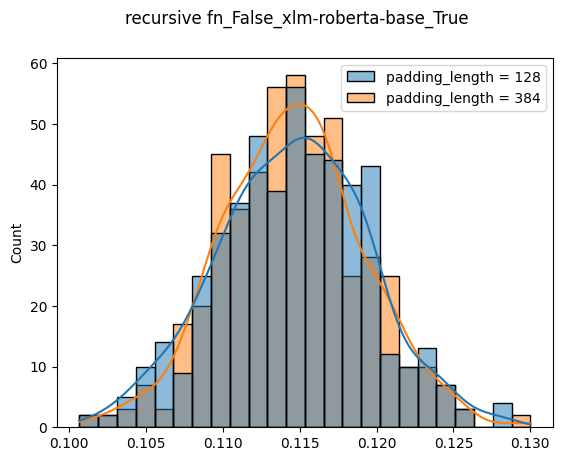

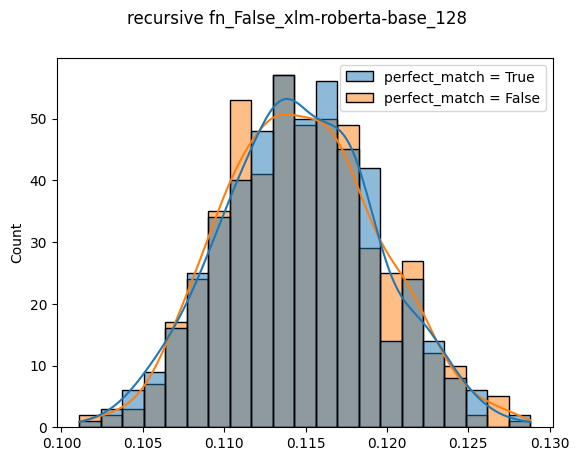

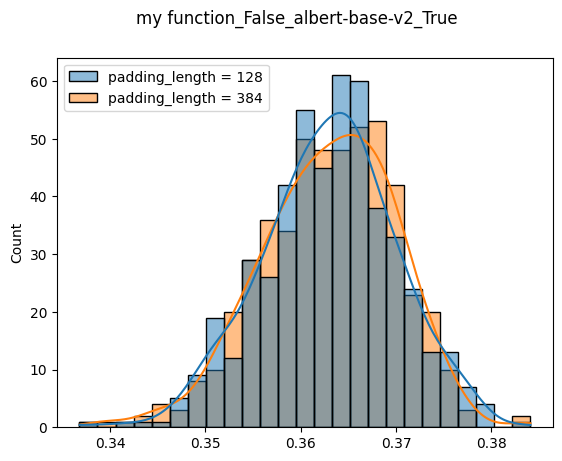

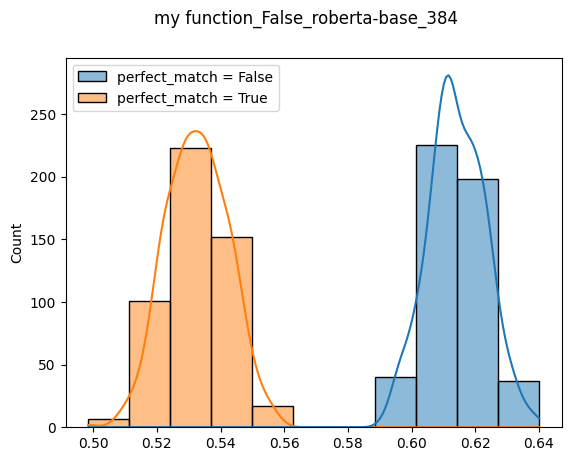

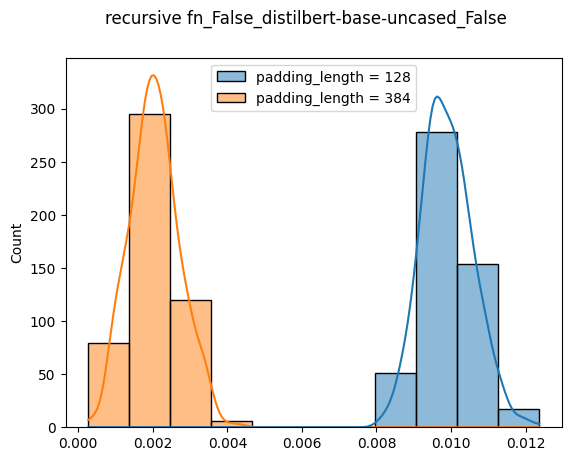

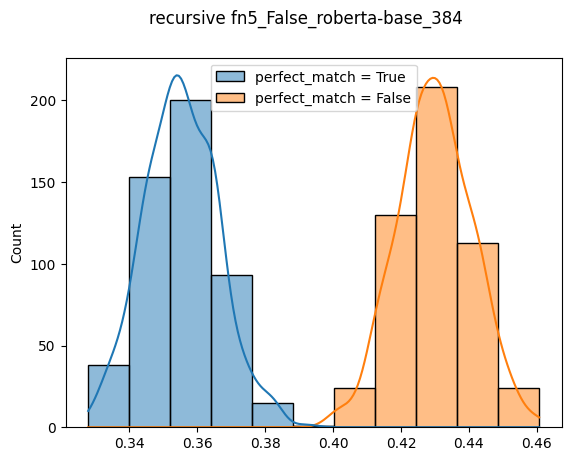

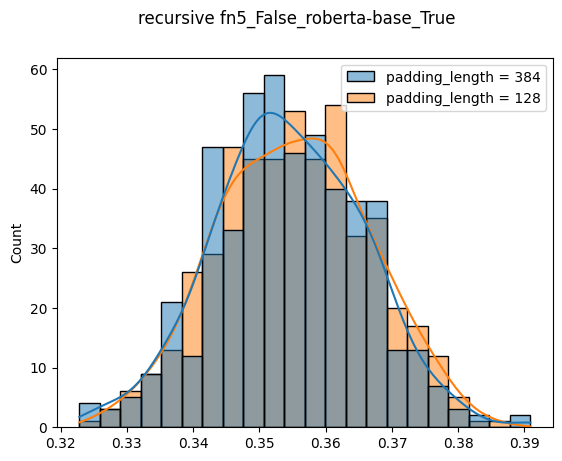

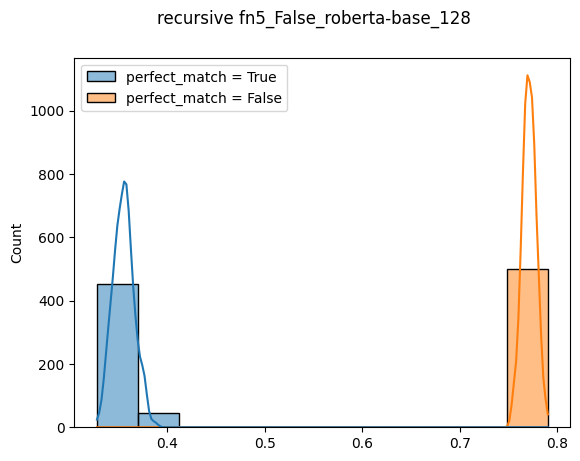

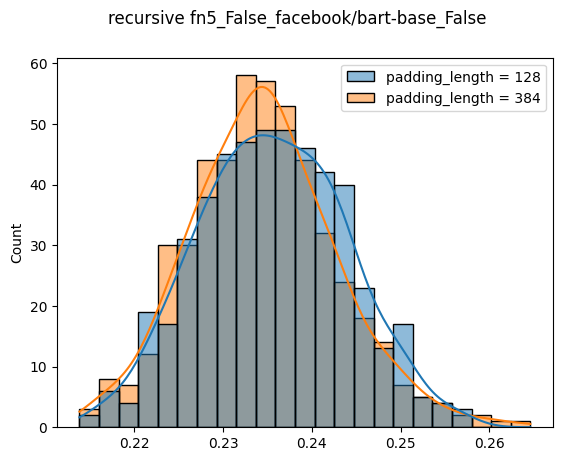

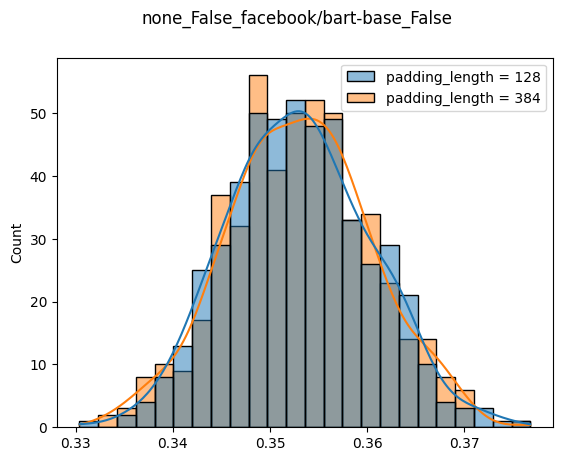

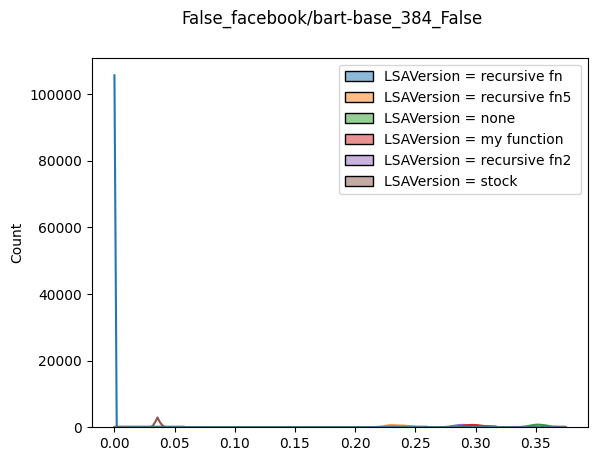

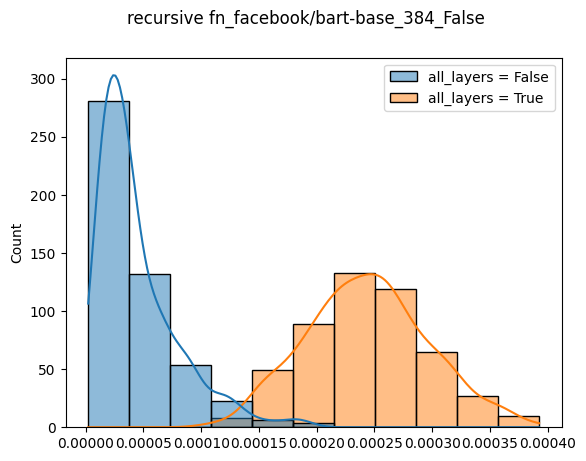

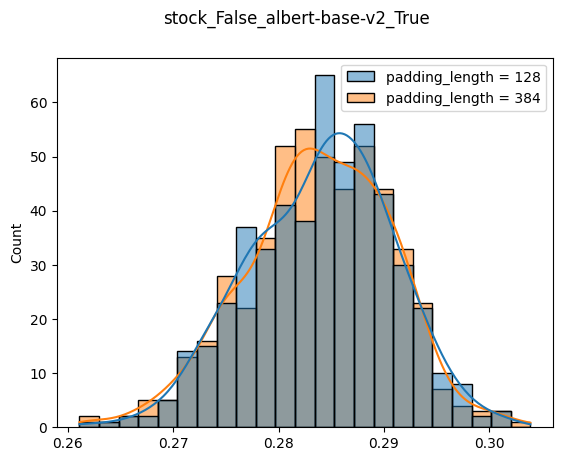

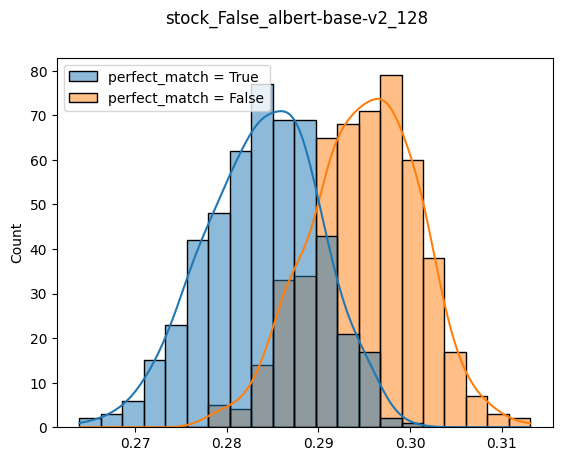

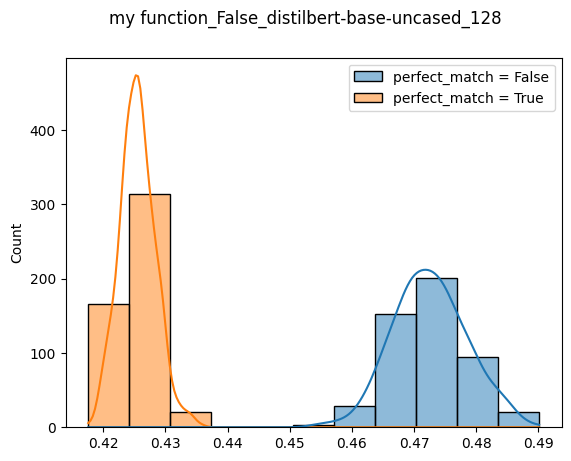

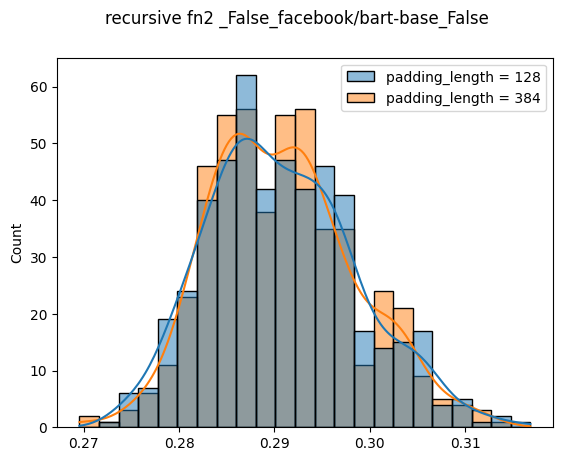

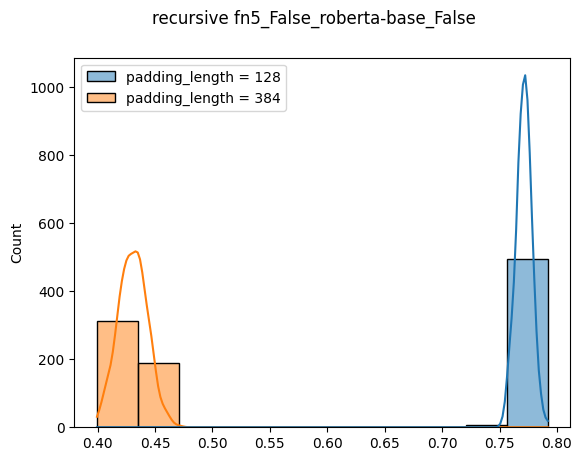

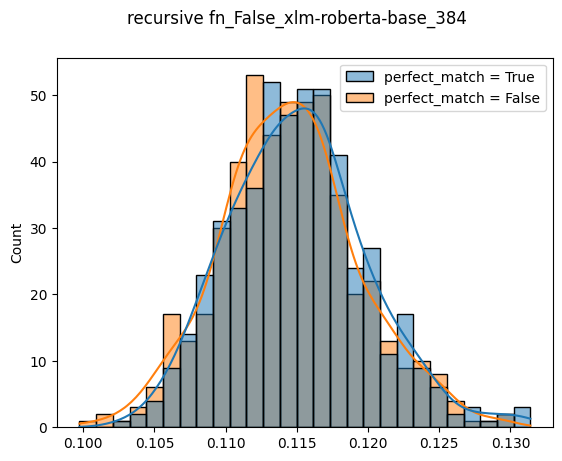

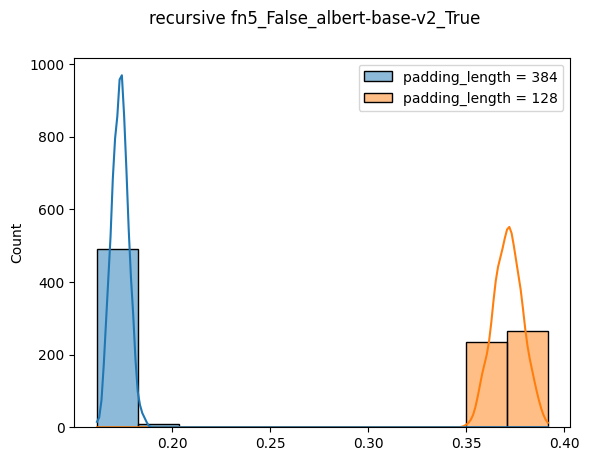

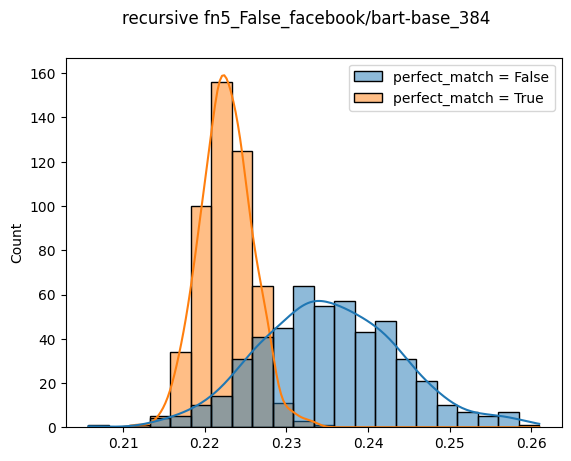

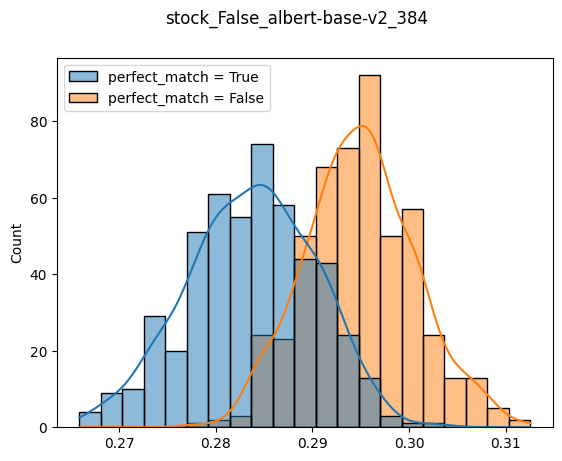

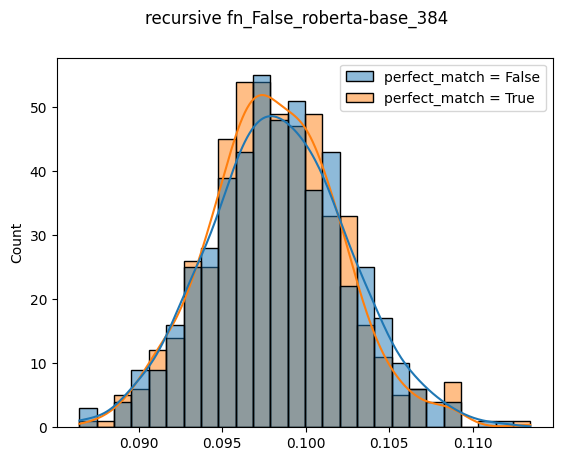

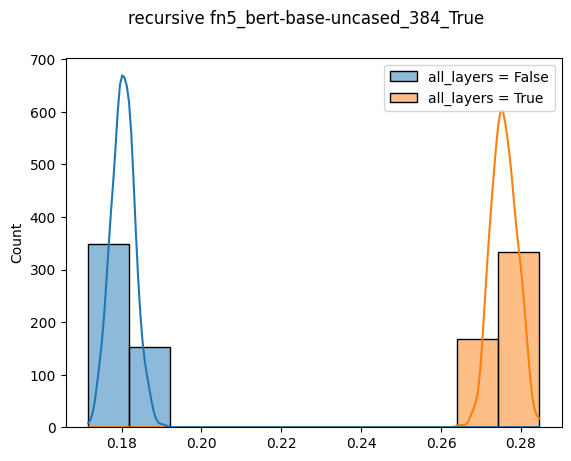

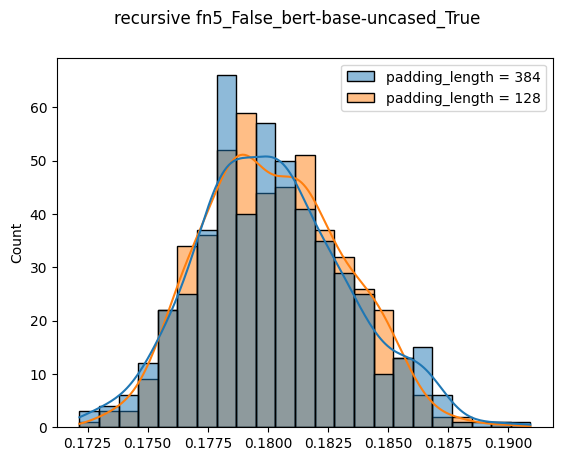

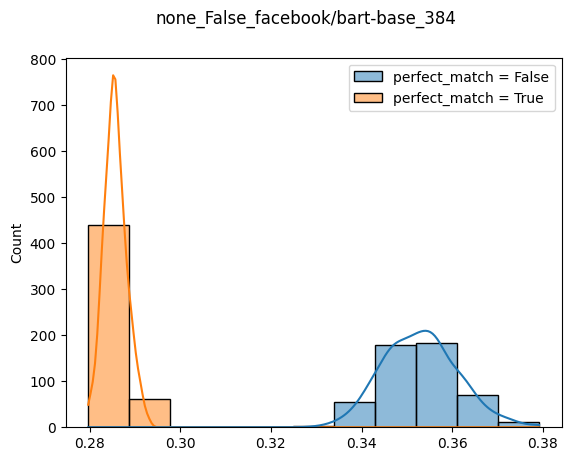

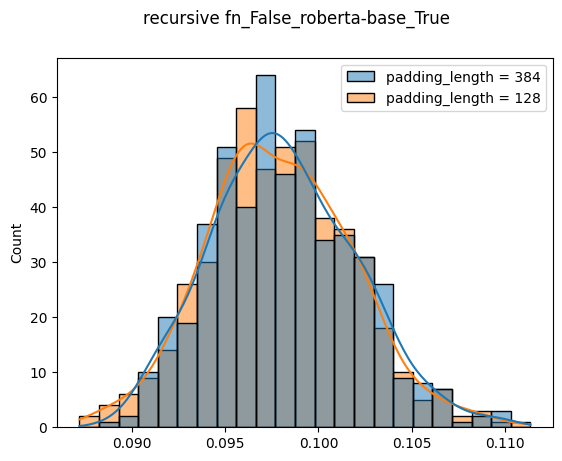

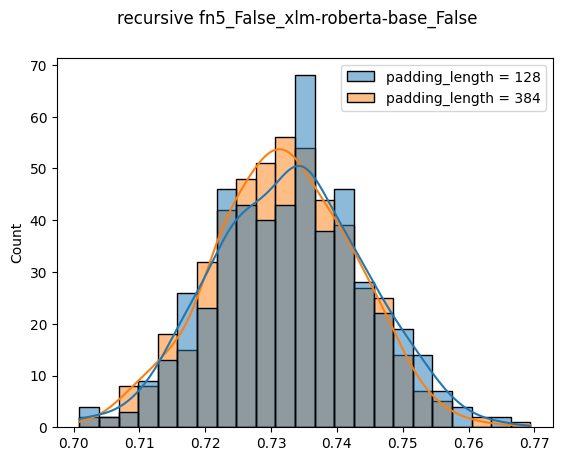

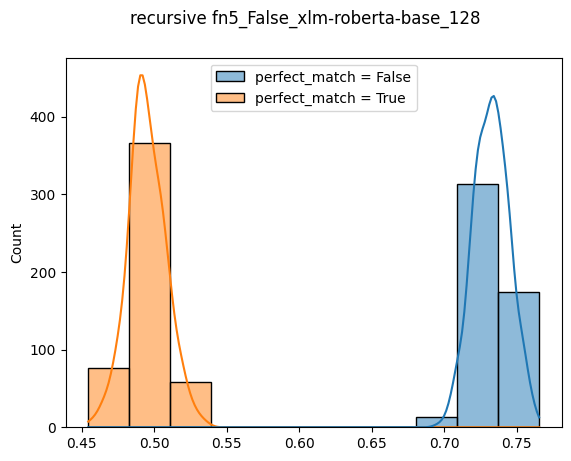

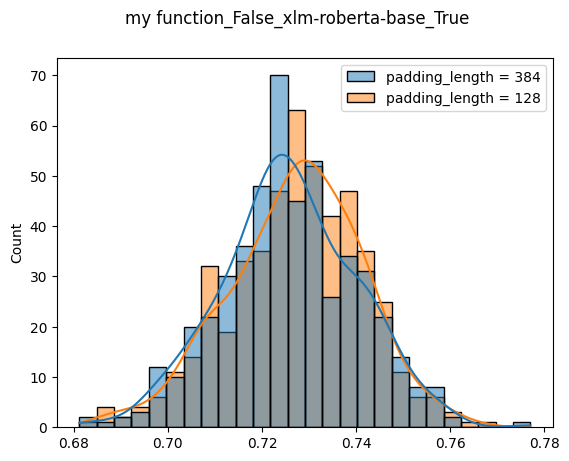

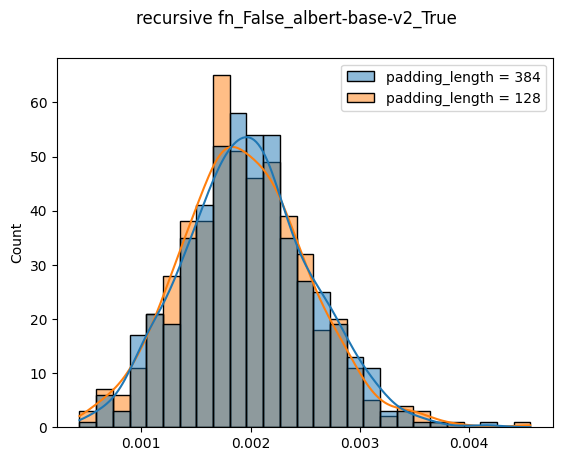

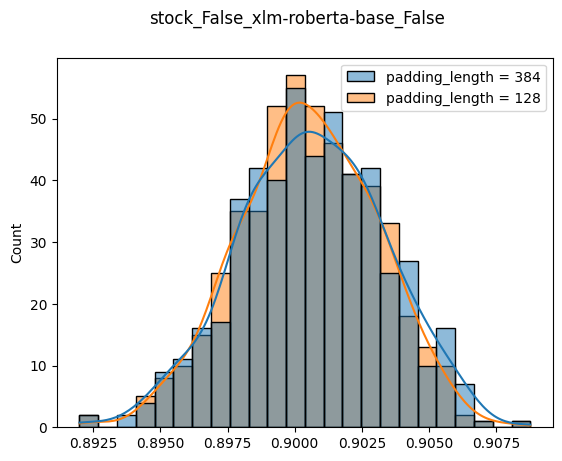

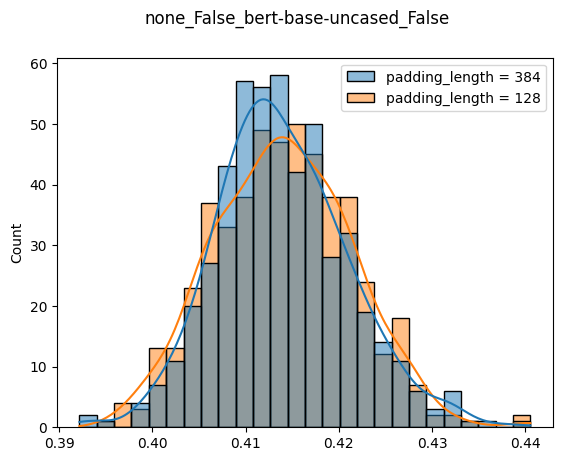

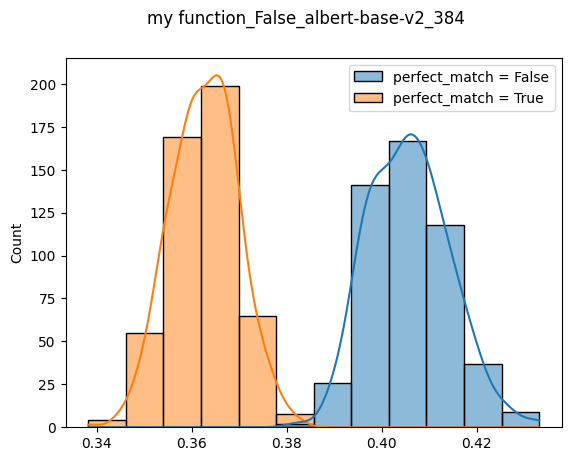

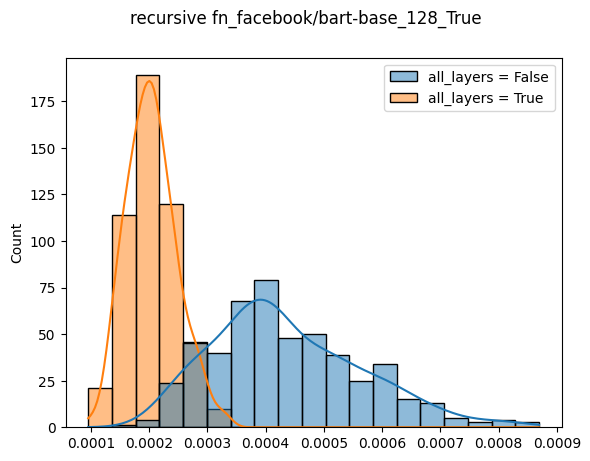

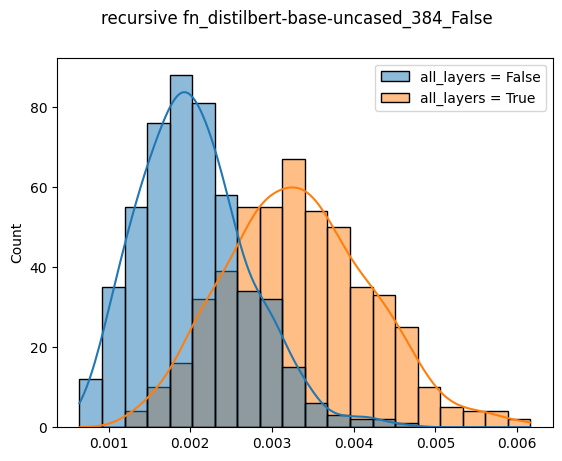

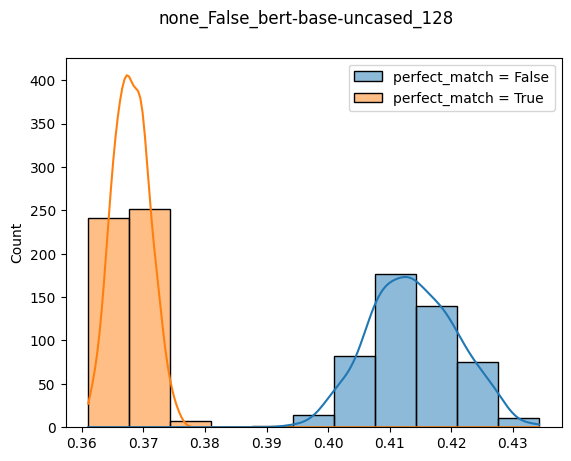

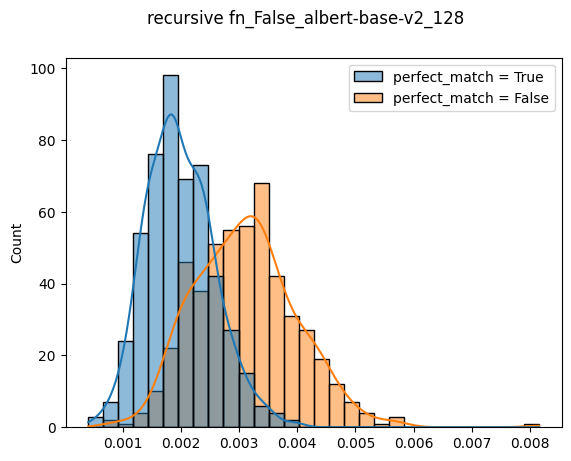

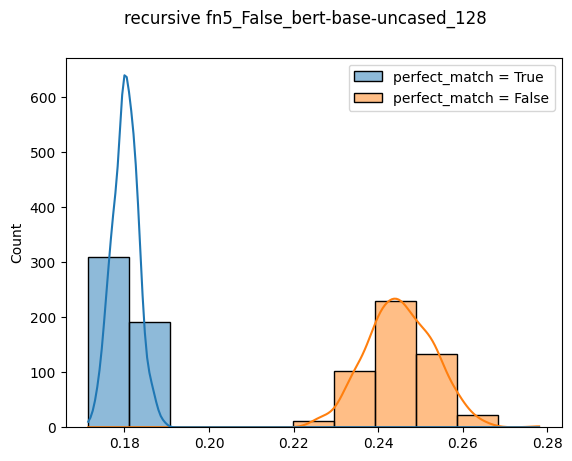

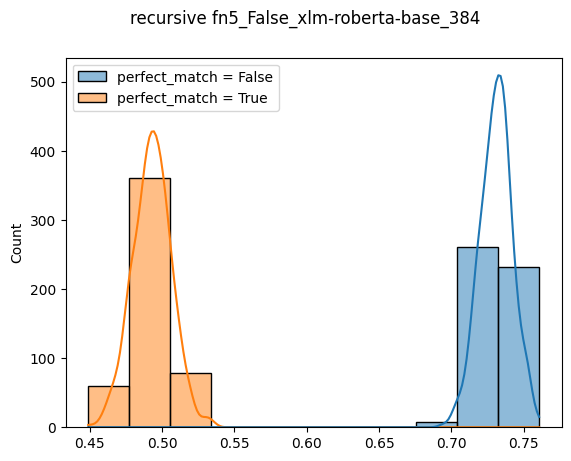

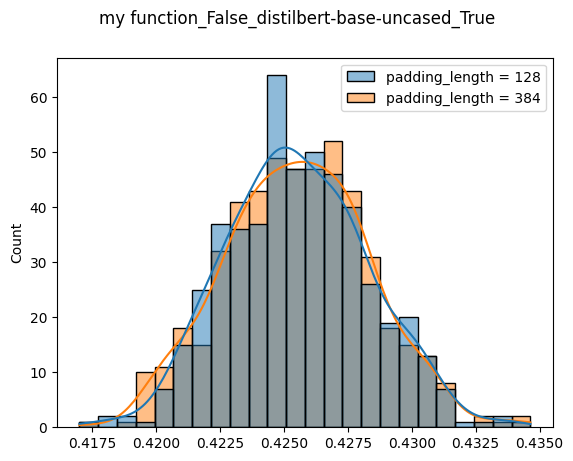

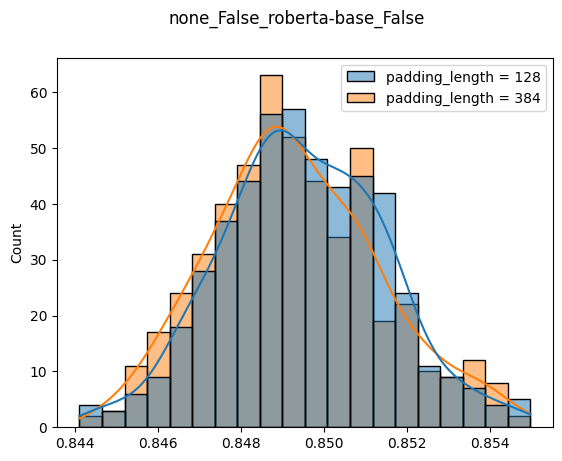

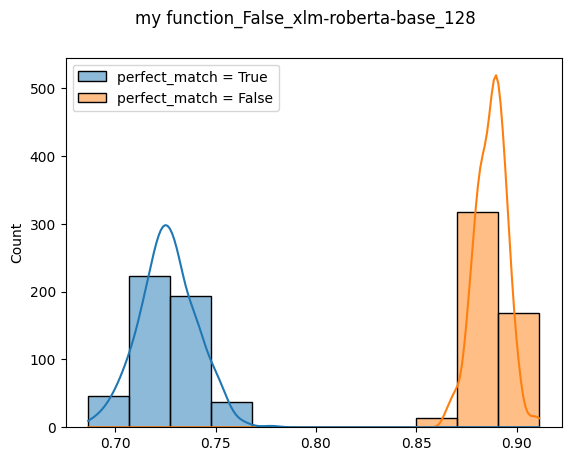

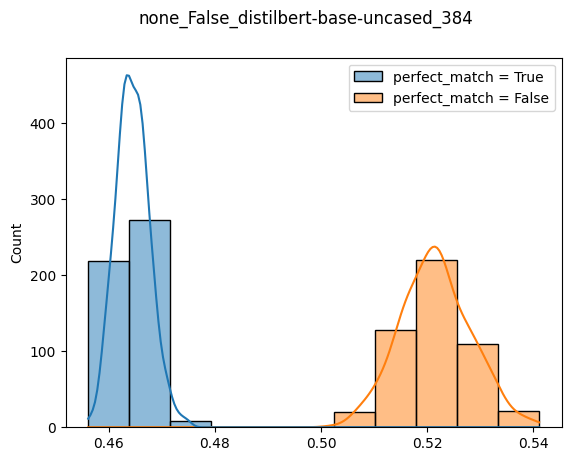

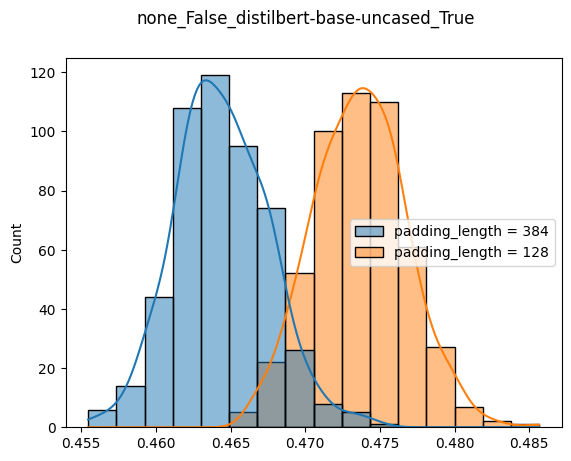

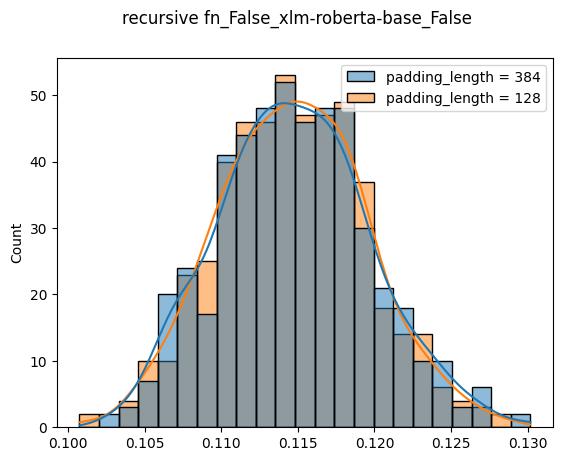

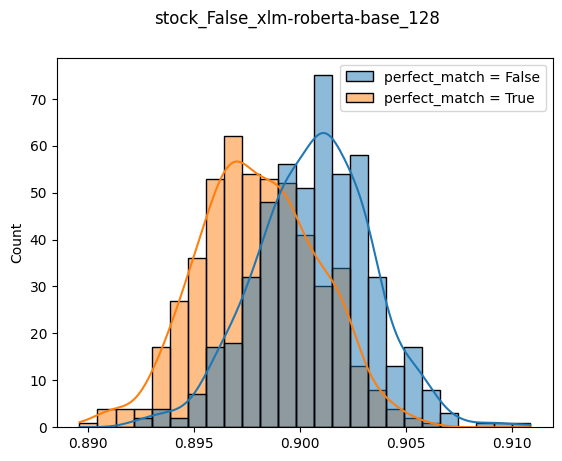

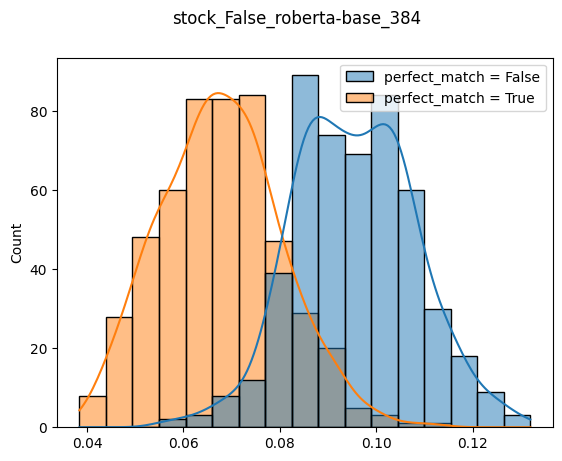

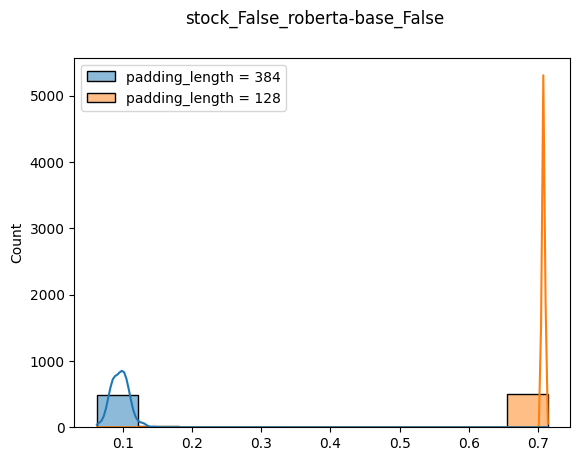

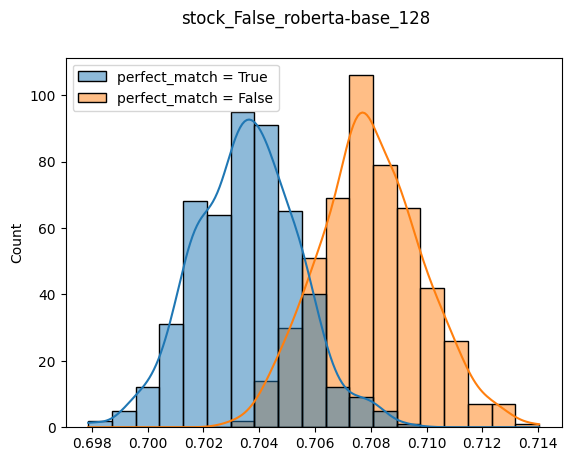

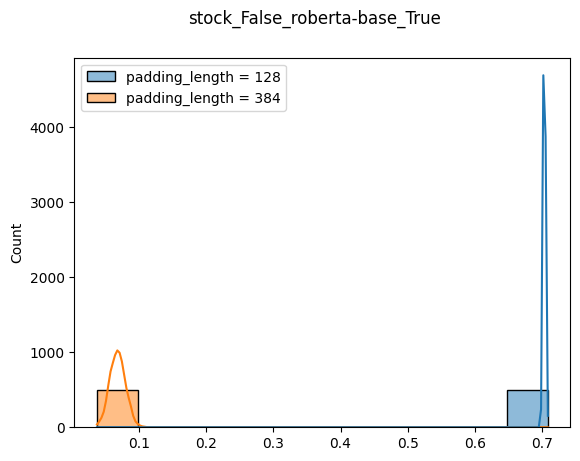

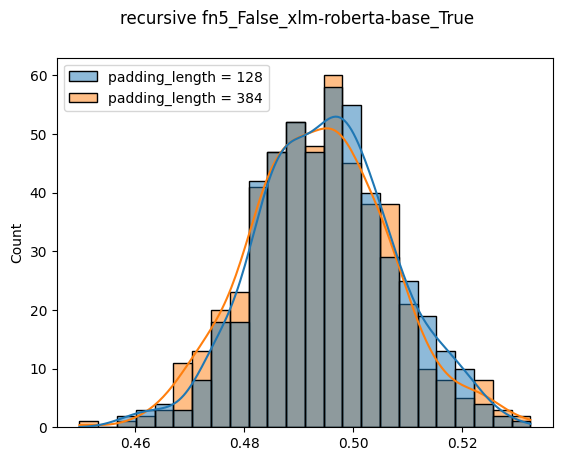

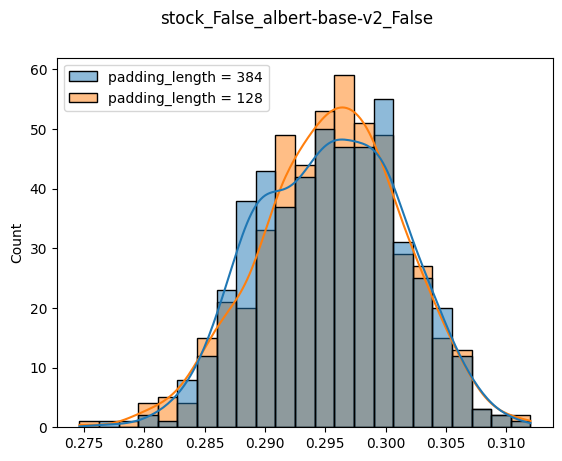

In [4]:
import seaborn as sns
# %matplotlib_inline
import matplotlib.pyplot as plt
from tqdm import tqdm
dir="./graphs"
import os
os.makedirs(dir,exist_ok=True)
for i,key in tqdm(enumerate(tests)):
    figure=plt.figure(i)
    plot=sns.histplot(data=tests[key], kde = True,)
    figure.suptitle(key)
    #escape keys
    name=key.replace("/","-")

    #save figure

    plt.savefig(os.path.join(dir,'{}.svg'.format(name)))